# Homework Week 3: Classification

## 1. Libraries

In [157]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## 2. Load dataset

In [158]:
usecols = ["age",
"job",
"marital",
"education",
"balance",
"housing",
"contact",
"day",
"month",
"duration",
"campaign",
"pdays",
"previous",
"poutcome",
"y"]

In [159]:
df = pd.read_csv("../../03-classification/Week-3/bank+marketing/bank/bank-full.csv", sep=";", usecols=usecols)
df.columns = df.columns.str.lower().str.replace(' ', '_')

df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


**Question 1
What is the most frequent observation (mode) for the column education?**

In [161]:
df.describe(include=["O"])

,job,marital,education,housing,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,3,12,4,2
top,blue-collar,married,secondary,yes,cellular,may,unknown,no
freq,9732,27214,23202,25130,29285,13766,36959,39922


## 3. Exploratory data analysis (EDA)

In [162]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

print(num_cols)
print(cat_cols)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']


### 1. Number of missing values

In [163]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### 2. Correlation

**Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.
What are the two features that have the biggest correlation?**

In [164]:
# Fill diagonal and upper half with NaNs
corr = df[num_cols].corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,age,balance,day,duration,campaign,pdays,previous
age,nan,nan,nan,nan,nan,nan,nan
balance,0.10,nan,nan,nan,nan,nan,nan
day,-0.01,0.00,nan,nan,nan,nan,nan
duration,-0.00,0.02,-0.03,nan,nan,nan,nan
campaign,0.00,-0.01,0.16,-0.08,nan,nan,nan
pdays,-0.02,0.00,-0.09,-0.00,-0.09,nan,nan
previous,0.00,0.02,-0.05,0.00,-0.03,0.45,nan


## 4. Data pre-processing

In [165]:
# Target encoding
df["y"] = (df["y"] == "yes").astype(int)

### 1. Splitting data into train, test, and validation

In [166]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=1)

In [167]:
len(df_train), len(df_test), len(df_val)

(27126, 9043, 9042)

In [168]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [169]:
# Split between X (features) and y (target)

X_train = df_train.drop('y', axis=1)
y_train = df_train['y']

X_test = df_test.drop('y', axis=1)
y_test = df_test['y']

X_val = df_val.drop('y', axis=1)
y_val = df_val['y']

In [170]:
print(len(X_train)*100/len(df))
print(len(X_test)*100/len(df))
print(len(X_val)*100/len(df))

59.99867288934109
20.001769480878547
19.999557629780362


### 1. Question 1: ROC AUC feature importance

In [171]:
for feature in num_cols:
    auc = roc_auc_score(y_train, X_train[feature])
    
    # If AUC < 0.5, invert the feature
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[feature])
        print(f"{feature}: -{auc:.4f}")
    else:
        print(f"{feature}: {auc:.4f}")


age: -0.5122
balance: 0.5888
day: -0.5260
duration: 0.8147
campaign: -0.5715
pdays: 0.5901
previous: 0.5986


In [172]:
def calculate_mi(series):
    return mutual_info_score(series, y_train)

df_mi = X_train[cat_cols].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')


display(df_mi.head())
display(df_mi.tail())

,MI
poutcome,0.028586
month,0.024460
contact,0.012256
housing,0.009158
job,0.008130


,MI
contact,0.012256
housing,0.009158
job,0.008130
education,0.002461
marital,0.002042


### 2. One-hot encoding

In [173]:
train_dict = X_train[cat_cols + num_cols].to_dict(orient='records')

In [174]:
train_dict[0]

{'job': 'entrepreneur',
 'marital': 'married',
 'education': 'tertiary',
 'housing': 'no',
 'contact': 'cellular',
 'month': 'jul',
 'poutcome': 'unknown',
 'age': 56,
 'balance': 40,
 'day': 11,
 'duration': 123,
 'campaign': 2,
 'pdays': -1,
 'previous': 0}

In [175]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [176]:
X_train = dv.transform(train_dict)

In [177]:
X_train.shape

(27126, 47)

In [178]:
dv.get_feature_names()

/opt/homebrew/Caskroom/miniforge/base/envs/khal0/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['age',
 'balance',
 'campaign',
 'contact=cellular',
 'contact=telephone',
 'contact=unknown',
 'day',
 'duration',
 'education=primary',
 'education=secondary',
 'education=tertiary',
 'education=unknown',
 'housing=no',
 'housing=yes',
 'job=admin.',
 'job=blue-collar',
 'job=entrepreneur',
 'job=housemaid',
 'job=management',
 'job=retired',
 'job=self-employed',
 'job=services',
 'job=student',
 'job=technician',
 'job=unemployed',
 'job=unknown',
 'marital=divorced',
 'marital=married',
 'marital=single',
 'month=apr',
 'month=aug',
 'month=dec',
 'month=feb',
 'month=jan',
 'month=jul',
 'month=jun',
 'month=mar',
 'month=may',
 'month=nov',
 'month=oct',
 'month=sep',
 'pdays',
 'poutcome=failure',
 'poutcome=other',
 'poutcome=success',
 'poutcome=unknown',
 'previous']

## 5. Training Model: Logistic regression

In [179]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [180]:
val_dict = X_val[cat_cols + num_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [181]:
model.predict_proba(X_val)

array([[0.9700324 , 0.0299676 ],
       [0.97689557, 0.02310443],
       [0.9792229 , 0.0207771 ],
       ...,
       [0.75207714, 0.24792286],
       [0.99781078, 0.00218922],
       [0.96227721, 0.03772279]])

In [182]:
y_pred = model.predict_proba(X_val)[:, 1]

In [183]:
y_pred

array([0.0299676 , 0.02310443, 0.0207771 , ..., 0.24792286, 0.00218922,
       0.03772279])

### Question 2: Training the model

In [184]:
y_pred_decision = (y_pred >= 0.5).astype(int)

# Manually calculate the accuracy
correct_predictions = (y_pred_decision == y_val).mean()  # Count the number of correct predictions

baseline_accuracy = correct_predictions

correct_predictions

0.8984737889847378

## 6. Evaluation

In [185]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.8984737889847378

### Confusion matrix

In [186]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [187]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [188]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [189]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[7751,  193],
       [ 725,  373]])

In [190]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.86, 0.02],
       [0.08, 0.04]])

### Precision and Recall

In [191]:
p = tp / (tp + fp)
p

0.6590106007067138

In [192]:
r = tp / (tp + fn)
r

0.33970856102003644

### ROC Curve

In [193]:
tpr = tp / (tp + fn)
tpr

0.33970856102003644

In [194]:
fpr = fp / (fp + tn)
fpr

0.024295065458207452

In [195]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    # p = tp / (tp + fp)
    # r =  tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn))

In [197]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
# df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)

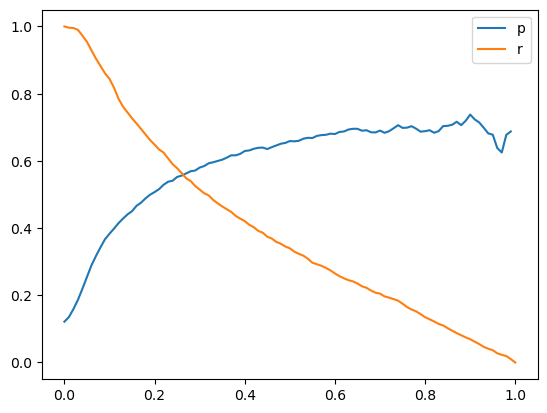

In [198]:
plt.plot(df_scores.threshold, df_scores['p'], label='p')
plt.plot(df_scores.threshold, df_scores['r'], label='r')
plt.legend()

In [207]:
df_scores['f1'] = 2 * (df_scores['p'] * df_scores['r'] )/ (df_scores['p'] + df_scores['r'])

df_scores.head(60)

,threshold,tp,fp,fn,tn,r,p,f1
0,0.00,1098,7944,0,0,1.000000,0.121433,0.216568
1,0.01,1094,7004,4,940,0.996357,0.135095,0.237930
2,0.02,1093,5788,5,2156,0.995446,0.158843,0.273969
3,0.03,1087,4742,11,3202,0.989982,0.186481,0.313844
4,0.04,1068,3799,30,4145,0.972678,0.219437,0.358089
5,0.05,1048,3071,50,4873,0.954463,0.254431,0.401763
6,0.06,1020,2509,78,5435,0.928962,0.289034,0.440890
7,0.07,993,2141,105,5803,0.904372,0.316847,0.469282
8,0.08,969,1859,129,6085,0.882514,0.342645,0.493632
9,0.09,945,1632,153,6312,0.860656,0.366705,0.514286


## 6. Evaluation: Cross Validation

In [219]:
def train(df, y, C):
    cat = df[cat_cols + num_cols].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[cat_cols + num_cols].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [209]:
!pip install tqdm

In [212]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [214]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [222]:
n_splits = 5

for C in tqdm([1.0]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/1 [00:00<?, ?it/s]

C=1.0 0.906 +- 0.006


In [223]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006
